In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

The corresponding light intensity for each current was also measured, before the cylindrical lens system, and for one power directly in front of the window.
The reduction due to the cylindrical lens system is from 40.5 mW $\rightarrow$ 37.6 mW, or 7.1%

In [2]:
current_power = {6.5: 40.5, 6.125: 35.2, 5.75: 30.5, 5.375: 24, 5: 17.5}
current_power = {key: val*(37.6/40.5) for key, val in current_power.items()}

In [3]:
fname = "2020_11_4.hdf"
dset_name = "1604539018 RC P2 F1 power scan"

devices = ("Seed1Amplifier", )

In [4]:
pmt_channel = 1
shutter_channel = 2

traces_currents = {cur: {'open': [], 'closed': []} for cur in np.linspace(5,6.5,5)}

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)
attr_name = 'Seed1Amplifier SetCurrentGUI'

In [5]:
seed1amp_currents = {idx: attrs[attr_name] for idx, attrs in pxie_attrs.items()}
seed1amp_currents = OrderedDict(sorted(seed1amp_currents.items()))

for idx, cur in seed1amp_currents.items():
    traces = pxie[idx]
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(np.append(pmt[:250], pmt[-100:]))
    shutter_state = traces[:,shutter_channel].mean() > 2e4
    if shutter_state:
        traces_currents[cur]['open'].append(pmt)
    else:
        traces_currents[cur]['closed'].append(pmt)

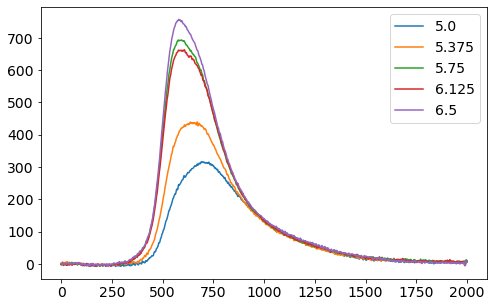

In [6]:
fig, ax = plt.subplots(figsize = (8,5))
for c in np.unique(list(seed1amp_currents.values())):
    ax.plot(np.mean(traces_currents[c]['open'], axis = 0), label = c)
#     ax.plot(np.mean(traces_currents[c]['closed'], axis = 0), label = c)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [7]:
for c in np.unique(list(seed1amp_currents.values())):
    io = np.trapz(np.mean(traces_currents[c]['open'], axis = 0))
    ic = np.trapz(np.mean(traces_currents[c]['closed'], axis = 0))
    print(f'{c:.3f} A -> {io/ic:.3f} ratio')

5.000 A -> 2.789 ratio
5.375 A -> 2.924 ratio
5.750 A -> 3.072 ratio
6.125 A -> 3.090 ratio
6.500 A -> 2.952 ratio


### Averaging Integrals

In [8]:
def ratio_error(a,b,σa,σb):
    return np.sqrt((a/b)**2 * ((σa/a)**2 + (σb/b)**2))

In [9]:
pmt_channel = 1
shutter_channel = 2

pmt_data = {c: [] for c in np.linspace(5,6.5,5)}
shutter_data = {c: [] for c in np.linspace(5,6.5,5)}

attr_name = 'Seed1Amplifier SetCurrentGUI'
for idx in range(1,len(pxie)+1):
    c = float(pxie_attrs[idx][attr_name])
    pmt_data[c].append(pxie[idx][:,pmt_channel])
    shutter_data[c].append(pxie[idx][:,shutter_channel].mean() > 2e4)
    
for key, val in pmt_data.items():
    pmt_data[key] = np.asarray(val)

for key, val in shutter_data.items():
    shutter_data[key] = np.asarray(val)

In [10]:
pmt_data_normalized = {}
for key, val in pmt_data.items():
    pmt_data_normalized[key] = -(val - np.mean(val[:,:250], axis = 1)[:, np.newaxis])

In [11]:
integrals = {}
for key, val in pmt_data_normalized.items():
    integrals[key] = np.trapz(val, axis = 1)

In [12]:
ratios = {}
for key, val in integrals.items():
    shutter_start = shutter_data[key][0]
    # select only values with the shutter open
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]
        
    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]
    inta = np.nanmean(val[mask_open])
    stda = np.nanstd(val[mask_open])/np.sqrt((~np.isnan(val[mask_open])).sum())
    intb = np.nanmean(val[mask_closed])
    stdb = np.nanstd(val[mask_closed])/np.sqrt((~np.isnan(val[mask_open])).sum())
    err = ratio_error(inta,intb, stda, stdb)
    ratios[key] = (inta/intb, err)
    print(f'{key:.2f} A -> {inta/intb:.3f} +/- {err:.3f}  ratio')

5.00 A -> 2.923 +/- 0.054  ratio
5.38 A -> 3.046 +/- 0.065  ratio
5.75 A -> 3.228 +/- 0.059  ratio
6.12 A -> 3.183 +/- 0.057  ratio
6.50 A -> 2.946 +/- 0.039  ratio


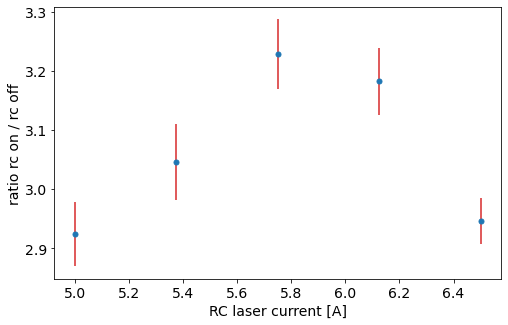

In [13]:
currents = list(ratios.keys())
ratio, err = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(currents, ratio, yerr = err, fmt = '.', ms = 10, ecolor = 'C3')

ax.set_xlabel('RC laser current [A]')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

(array([   6.,   25.,  144.,  692., 1239.,  650.,  173.,   42.,   23.,
           6.]),
 array([-150237.808 , -105456.2144,  -60674.6208,  -15893.0272,
          28888.5664,   73670.16  ,  118451.7536,  163233.3472,
         208014.9408,  252796.5344,  297578.128 ]),
 <BarContainer object of 10 artists>)

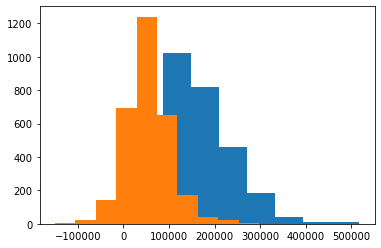

In [14]:
plt.hist(integrals[5][::2])
plt.hist(integrals[5][1::2])

5.00 A -> 2.867 +/- 0.051  ratio
5.38 A -> 2.982 +/- 0.062  ratio
5.75 A -> 3.175 +/- 0.057  ratio
6.12 A -> 3.167 +/- 0.052  ratio
6.50 A -> 2.889 +/- 0.036  ratio


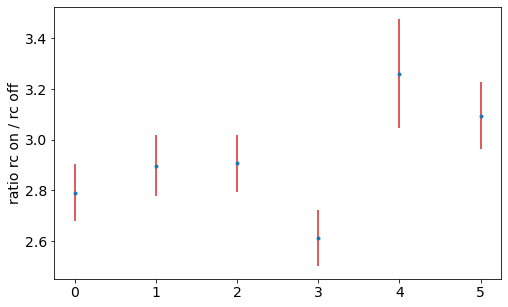

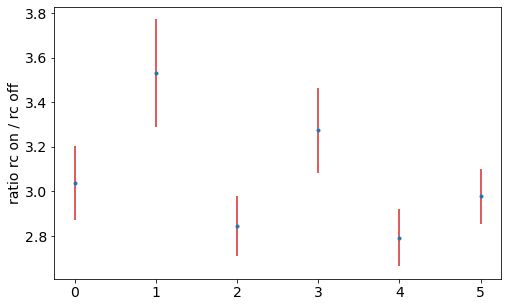

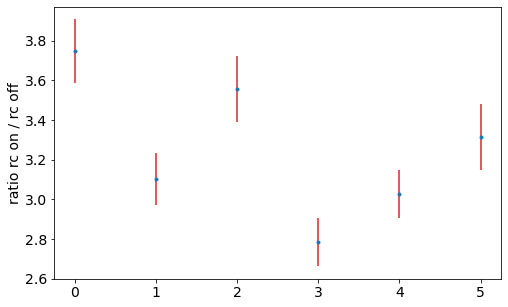

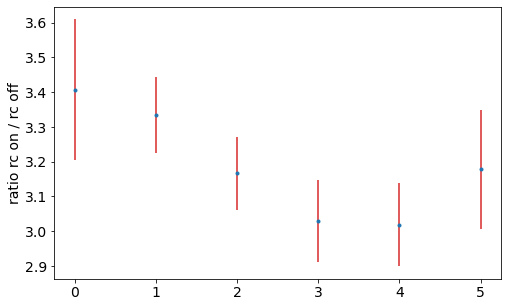

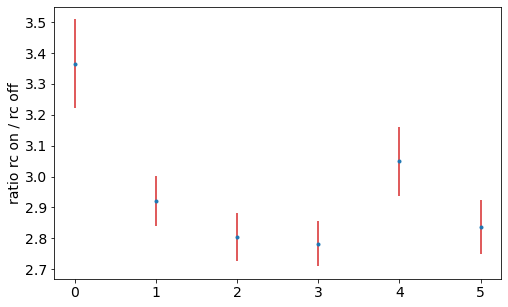

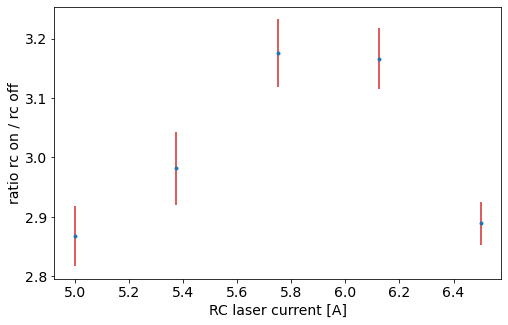

In [15]:
ratios = []
ratios_errs = []
navg = 500
for c in np.linspace(5,6.5,5):
    shutter_start = shutter_data[c][0]
    # select only values with the shutter open
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]

    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]

    into = integrals[c][mask_open].reshape(-1,navg).mean(axis = 1)
    intc = integrals[c][mask_closed].reshape(-1,navg).mean(axis = 1)
    r = into/intc
    stdo = integrals[c][mask_open].reshape(-1,navg).std(axis = 1)/np.sqrt(navg)
    stdb = integrals[c][mask_closed].reshape(-1,navg).std(axis = 1)/np.sqrt(navg)
    rerr = ratio_error(into, intc, stdo, stdb)
    
    ratios.append(np.average(r, weights = 1/rerr**2))
    ratios_errs.append(np.sqrt(1/np.sum(1/(rerr**2))))
    
    fig, ax = plt.subplots(figsize = (8,5))

    ax.errorbar(x = np.linspace(0,len(r)-1,len(r)), y = r, 
                yerr = rerr, fmt = '.', ecolor = 'C3')
    ax.set_ylabel('ratio rc on / rc off')
    set_fontsize(ax, 14)
    print(f'{c:.2f} A -> {np.average(r, weights = 1/rerr**2):.3f} +/- {np.sqrt(1/np.sum(1/(rerr**2))):.3f}  ratio')
    
fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(x = np.linspace(5,6.5,5), y = ratios, 
            yerr = ratios_errs, fmt = '.', ecolor = 'C3')

ax.set_xlabel('RC laser current [A]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)

In [16]:
data_currents = {cur: [] for cur in np.linspace(5,6.5,5)}

for idx, cur in seed1amp_currents.items():
    traces = pxie[idx]
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(np.append(pmt[:250], pmt[-100:]))
    data_currents[cur].append(pmt)
        
for key, val in data_currents.items():
    data_currents[key] = np.asarray(val)

5.00 A -> 2.789 +/- 0.004  ratio
5.38 A -> 2.924 +/- 0.004  ratio
5.75 A -> 3.072 +/- 0.003  ratio
6.12 A -> 3.090 +/- 0.003  ratio
6.50 A -> 2.952 +/- 0.003  ratio


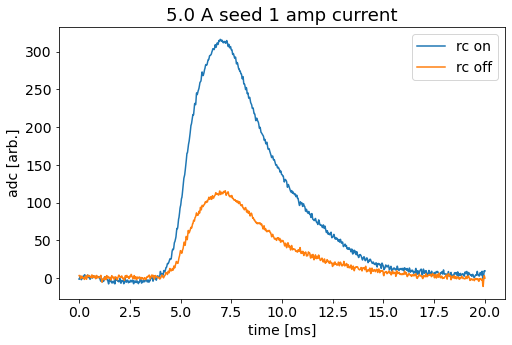

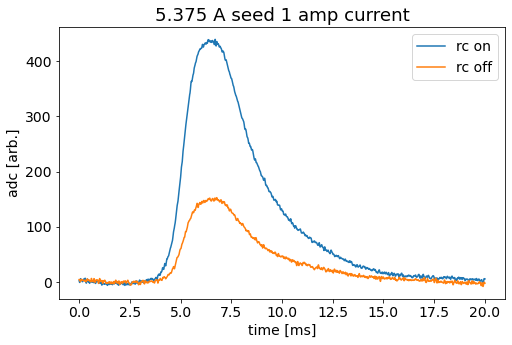

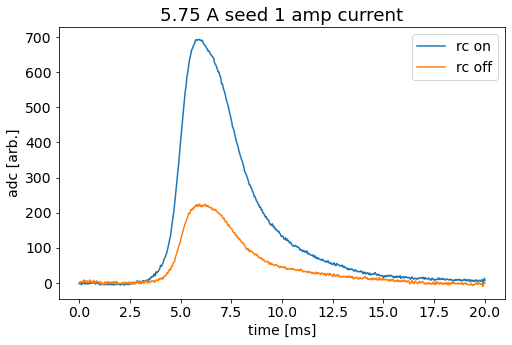

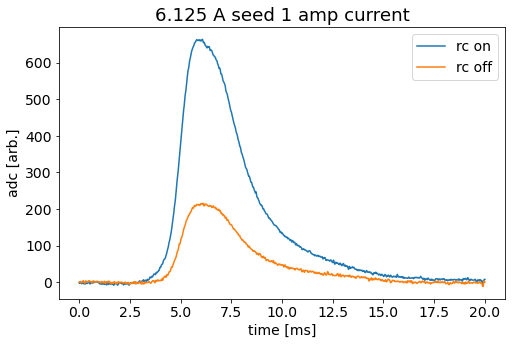

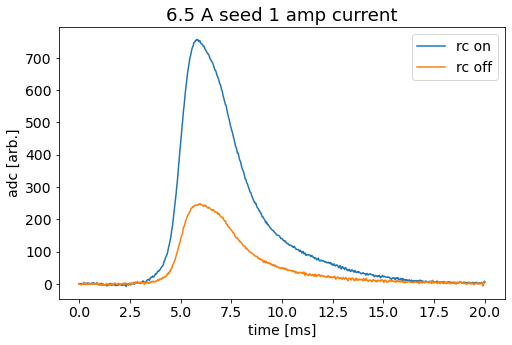

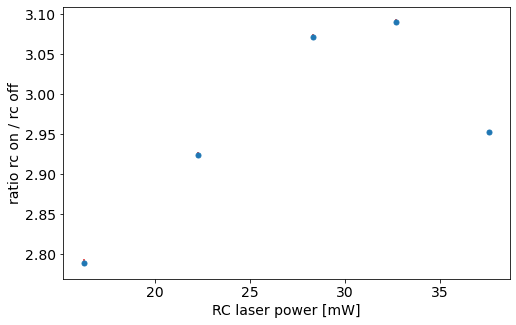

In [17]:
ratios = {}
x = np.linspace(0,1,2000)*20

for c, val in data_currents.items():
    dat = val
    shutter_start = shutter_data[c][0]
    # select only values with the shutter open
    
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]
        
    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]
        
    d_open = dat[mask_open]
    d_closed = dat[mask_closed]
    
    inta = np.trapz(np.mean(d_open, axis = 0))
    intb = np.trapz(np.mean(d_closed, axis = 0))
    stda = np.sqrt(np.sum(((np.std(d_open, axis = 0))/np.sqrt(len(d_open)))**2))
    stdb = np.sqrt(np.sum(((np.std(d_closed, axis = 0))/np.sqrt(len(d_closed)))**2))
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(x, np.mean(d_open, axis = 0), label = 'rc on')
    ax.plot(x, np.mean(d_closed, axis = 0), label = 'rc off')
    ax.set_title(f'{c} A seed 1 amp current', fontsize = 14)
    ax.set_xlabel('time [ms]')
    ax.set_ylabel('adc [arb.]')
    ax.legend(fontsize = 14)
    set_fontsize(ax, 14)
    
    err = ratio_error(inta,intb, stda, stdb)
    ratios[c] = (inta/intb, err)
    print(f'{c:.2f} A -> {inta/intb:.3f} +/- {err:.3f}  ratio')

currents = list(ratios.keys())
ratio, err = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar([current_power[c] for c in currents], ratio, yerr = err, fmt = '.', ms = 10, ecolor = 'C3')

ax.set_xlabel('RC laser power [mW]')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)